In [381]:
#std lib
from collections import OrderedDict
from getpass import getpass
import warnings
warnings.filterwarnings('ignore') # to suppress some astropy deprecation warnings

# 3rd party
import numpy as np
import pylab as plt
from astropy import utils, io, convolution, wcs
from astropy.visualization import make_lupton_rgb
from astropy.coordinates import name_resolve
from pyvo.dal import sia
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

# set up Simple Image Access (SIA) service
DEF_ACCESS_URL = "http://datalab.noao.edu/sia/des_dr1"
svc = sia.SIAService(DEF_ACCESS_URL)

In [382]:
print(qc.schema('gaia_dr2',format='',profile='default'))


Schema: gaia_dr2

      Table Name   Description
      ----------   -----------
         allwise   Allwise AGN Gaia DR2 cross-identification
         cepheid   Cepheid stars (Gaia collaboration)
         des_dr1   1.5-arcsec positional crossmatch against DES DR1
     gaia_source   Primary object table
            iers   IERS GaiaDR2 cross-identification
    light_curves   Light-curve data
             lpv   Long Period Variable stars (Gaia collaboration)
          ls_dr5   1.5-arcsec positional crossmatch against Legacy Survey DR5
          ls_dr6   1.5-arcsec positional crossmatch against Legacy Survey DR6
         nsc_dr1   1.5-arcsec positional crossmatch against NSC DR1
        numtrans   Calibrated FoV transit photometry from CU5, consolidated a
                   nd provided by CU7 for variable stars in Gaia DR2 (epoch_p
                   hotometry, part 1) ( Gaia collaboration)
              rm   Rotation period in segment, part 1 (vari_rotation_modulati
                   on)

In [383]:
# Dwarf names from Bechtol et al. (2015)
names = ['Eri III']

radius = 1. # search radius in degrees

# columns to query for
columns = '''ra,dec,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,flags_g,flags_i,flags_r,flags_z,
    flux_auto_g,fluxerr_auto_g,flux_auto_i,fluxerr_auto_i,spread_model_g,spread_model_i,
    spread_model_r,spread_model_z,class_star_g,class_star_i,class_star_r,class_star_z,
    kron_radius,tilename,coadd_object_id'''

In [384]:
# a function to retrieve data around a point in the sky
def getData(ra,dec,radius=2.0,columns='*'):

    query_template =\
    """SELECT {0} FROM des_dr1.main
       WHERE q3c_radial_query(ra,dec,{1},{2},{3})"""

    query = query_template.format(columns,ra,dec,radius)
    
    try:
        result = qc.query(sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = convert(result,'pandas')
    
    return df

# gets coordinates of a named source
def resolve_coordinates(name):
    try:
        coords = name_resolve.get_icrs_coordinates(name)
    except Exception as e:
        raise

    ra = coords.ra.to('deg').value
    dec = coords.dec.to('deg').value      

    return coords, ra, dec

In [385]:
dgs = OrderedDict([(name,dict()) for name in names]) # empty dictionary of dictionaries

# loop over dwarfs, resolving coordinates and querying for photometry data
for j,name in enumerate(dgs.keys()):
    print('{:s}: resolving coordinates and querying for data'.format(name))
    coords, ra0, dec0 = resolve_coordinates(name)
    dgs[name]['ra0'] = ra0
    dgs[name]['dec0'] = dec0
    df = getData(ra0,dec0,radius=radius,columns=columns)
    dgs[name]['df'] = df
print("Done.")

Eri III: resolving coordinates and querying for data
Done.


In [386]:
median_ra = (np.median(dgs[name]['df']['ra'].values))
print(median_ra)

35.697018


In [387]:
median_dec = (np.median(dgs[name]['df']['dec'].values))
print(median_dec)

-52.282731


# Get DES x Gaia stars

In [388]:
# a function to retrieve data around a point in the sky
def getData(ra,dec,columns='*'):

    query_template =\
    """SELECT {0} FROM des_dr1.des_gaia2
       WHERE q3c_radial_query(ra,dec,{1},{2},{3})"""

    query = query_template.format(columns,ra,dec,radius)
    
    try:
        result = qc.query(sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = convert(result,'pandas')
    
    return df

In [389]:
# Standard notebook imports
from __future__ import print_function
import getpass
from dl import authClient, queryClient, storeClient

In [390]:
# Get the security token for the datalab user
token = authClient.login ('edarraghford',getpass.getpass('Account password: '))
#password = Wavelets2020
if not authClient.isValidToken (token):
    print ('Error: invalid user login (%s)' % token)
else:
    print ("Login token:   %s" % token)

Account password: ········
Login token:   edarraghford.2546.2546.$1$egeiEetm$QNA1YlkiCyTOXTtJWTiAp1


In [391]:
query = 'select source_id, b, l, ra, dec, parallax, parallax_error, parallax_pmdec_corr, parallax_pmra_corr, pmdec, pmdec_error, pmra, pmra_error, pmra_pmdec_corr, radial_velocity, radial_velocity_error, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag from gaia_dr2.gaia_source where ra <= ' + str(median_ra+1) + ' and ra >= ' + str(median_ra-1)+ ' and dec >= ' + str(median_dec-1) + ' and dec <= ' + str(median_dec+1)
response = queryClient.query(token, adql = query, fmt = 'csv')

In [392]:
reader = csv.reader(response.split('\n'), delimiter=',') 
results = []

i = 0
for row in reader: # each row is a list
    results.append(row)
    i+=1

In [393]:
result_array = np.asarray(results[1:-2])

In [394]:
gids = [int(numeric_string) for numeric_string in result_array[:,0]]

In [395]:
import pandas as pd
dgaia = pd.DataFrame()

In [396]:
keys = ["id", "b", "l", "ra", "dec", "parallax", "parallax_err",
                      "parallax_pmdec_corr", "parallax_pmra_corr", "pmdec", "pmdec_err",
                     "pmra", "pmra_err", "pmra_pmdec_corr", "vrad", "vrad_err",
                     "Gmag", "BPmag", "RPmag"]

In [397]:
dgaia = pd.DataFrame({"id": [], "b": [], "l": [], "ra": [], "dec": [], "parallax": [], "parallax_err": [],
                      "parallax_pmdec_corr": [], "parallax_pmra_corr": [], "pmdec": [], "pmdec_err": [],
                     "pmra": [], "pmra_err": [], "pmra_pmdec_corr": [], "vrad": [], "vrad_err": [],
                     "Gmag": [], "BPmag": [], "RPmag": [],})

In [398]:
dgaia_all = pd.DataFrame({"id": [], "b": [], "l": [], "ra": [], "dec": [], "parallax": [], "parallax_err": [],
                      "parallax_pmdec_corr": [], "parallax_pmra_corr": [], "pmdec": [], "pmdec_err": [],
                     "pmra": [], "pmra_err": [], "pmra_pmdec_corr": [], "vrad": [], "vrad_err": [],
                     "Gmag": [], "BPmag": [], "RPmag": [],})

In [399]:
for i in range(len(keys)):
    if i == 0:
        result_array_0 = [int(numeric_string) for numeric_string in result_array[:,i]]
        dgaia[keys[i]] = result_array_0
    else:
        result_array_i = [np.float32(numeric_string) for numeric_string in result_array[:,i]]
        dgaia[keys[i]] = result_array_i

In [400]:
cut_idx = (dgaia['parallax'] - dgaia['parallax_err']) > 0.1

In [401]:
dgaia_short = dgaia[cut_idx]

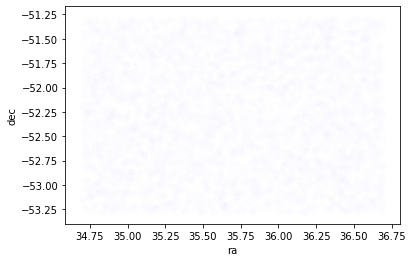

In [402]:
#ididx = dgaia_all['id'] != dg
plt.scatter(dgaia_short['ra'].values, dgaia_short['dec'].values, c='b',alpha=0.005)
#plt.scatter(dgaia_retii['ra'].values, dgaia_retii['dec'].values, c='m',alpha=0.005)
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

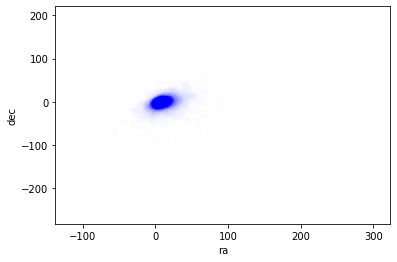

In [403]:
#ididx = dgaia_all['id'] != dg
plt.scatter(dgaia_short['pmra'].values, dgaia_short['pmdec'].values, c='b',alpha=0.005)
#plt.scatter(dgaia_retii['pmra'].values, dgaia_retii['pmdec'].values, c='m',alpha=0.005)
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

In [404]:
full_field = np.c_[dgaia_short['ra'].as_matrix(), dgaia_short['dec'].as_matrix(), 
                   dgaia_short['pmra'].as_matrix(), dgaia_short['pmdec'].as_matrix()]
#dwarf_field = np.c_[dgaia_retii['ra'].as_matrix(), dgaia_retii['dec'].as_matrix(), 
                #   dgaia_retii['pmra'].as_matrix(), dgaia_retii['pmdec'].as_matrix()]


In [405]:
def make_field_image(full_field, n_pos= 65, n_vel=65):
    pos_min, pos_max =  np.min(full_field, axis =0)[:2], np.max(full_field, axis =0)[:2]
    ra_min, ra_max = median_ra-1, median_ra+1
    dec_min, dec_max = median_dec-1, median_dec+1
    
    
    vra_min, vra_max = -20, 20
    vdec_min, vdec_max =-20,20


    field_image, _ = np.histogramdd(full_field,\
                            bins=(np.linspace(ra_min, ra_max, n_pos),
                                  np.linspace(dec_min, dec_max, n_pos), 
                                  np.linspace(vra_min, vra_max, n_vel),
                                  np.linspace(vdec_min, vdec_max, n_vel) ) )
    
    return field_image

In [406]:
field_image = make_field_image(full_field)
#dwarf_image = make_field_image(dwarf_field)

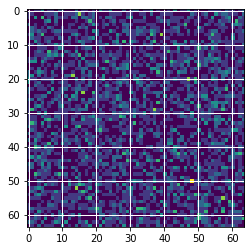

In [407]:
plt.imshow(field_image.sum(axis = (2,3)).T)
plt.grid(color='w', linestyle='-', linewidth=1)


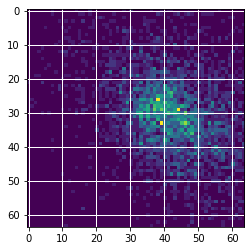

In [408]:
plt.imshow(field_image.sum(axis = (0,1)).T)
plt.grid(color='w', linestyle='-', linewidth=1)


In [409]:
from scipy import ndimage


def filter_layer(im, l = [2.0]):
    " return im filtered by the l filters"
    
    return np.stack([ndimage.filters.gaussian_filter(im, l) for l in l])

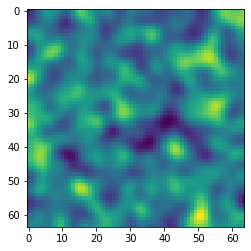

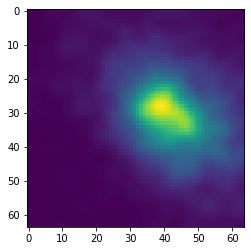

In [410]:
filtered_ims = ndimage.filters.gaussian_filter(field_image, 2.0)
plt.imshow(filtered_ims.sum(axis = (2,3)).T)
plt.show()

plt.imshow(filtered_ims.sum(axis = (0,1)).T)
plt.show()

['Eri III']


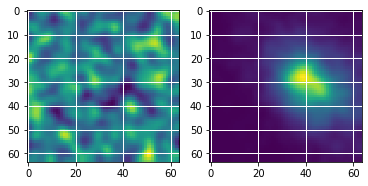

bior1.1
scale = 0.5 degrees


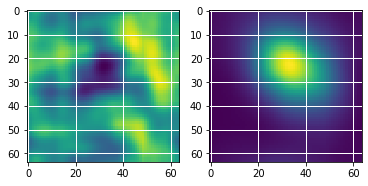

scale = 0.25 degrees


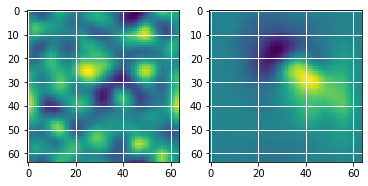

scale = 0.125 degrees


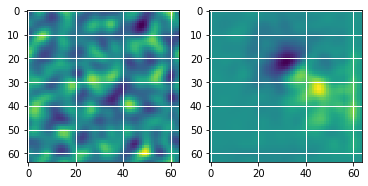

scale = 0.0625 degrees


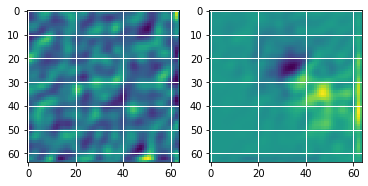

bior2.2
scale = 0.5 degrees


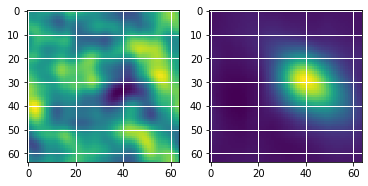

scale = 0.25 degrees


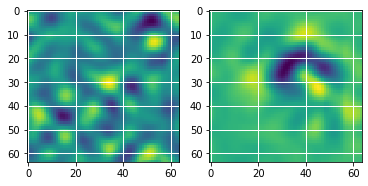

scale = 0.125 degrees


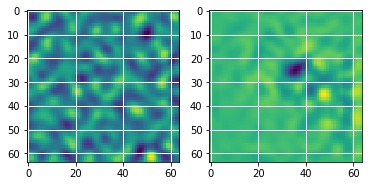

scale = 0.0625 degrees


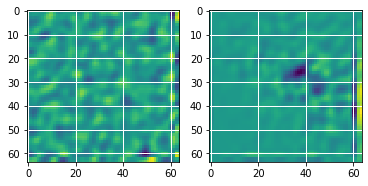

bior3.3
scale = 0.5 degrees


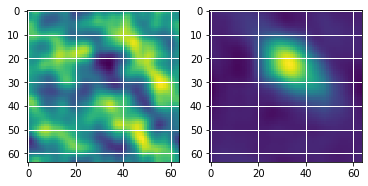

scale = 0.25 degrees


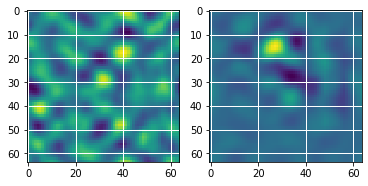

scale = 0.125 degrees


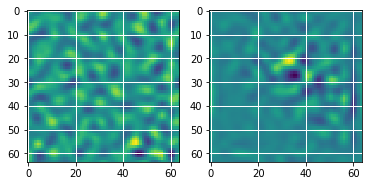

scale = 0.0625 degrees


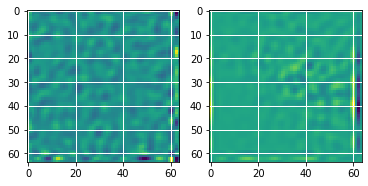

bior4.4
scale = 0.5 degrees


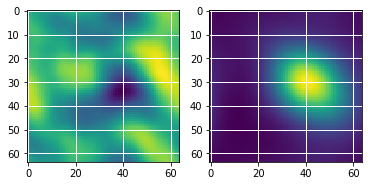

scale = 0.25 degrees


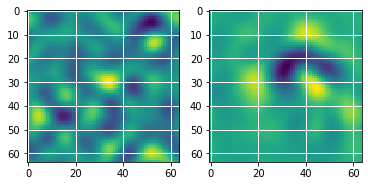

scale = 0.125 degrees


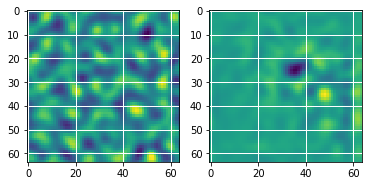

scale = 0.0625 degrees


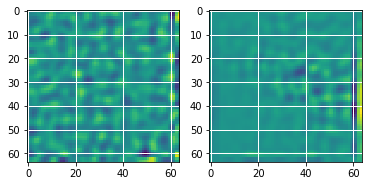

bior5.5
scale = 0.5 degrees


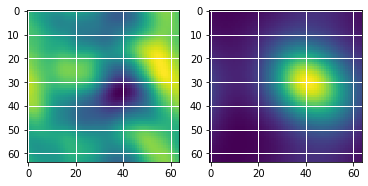

scale = 0.25 degrees


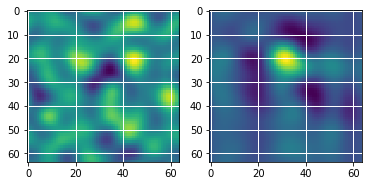

scale = 0.125 degrees


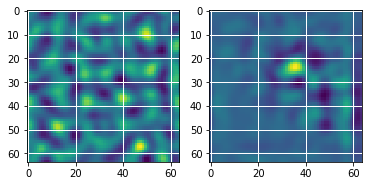

scale = 0.0625 degrees


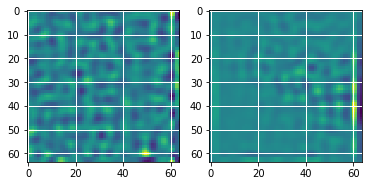

bior6.8
scale = 0.5 degrees


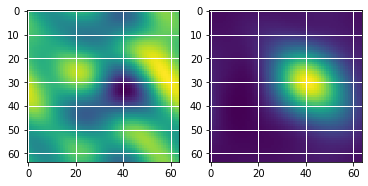

scale = 0.25 degrees


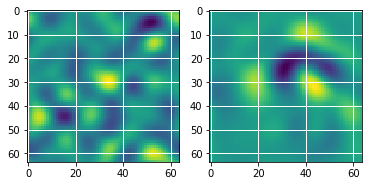

scale = 0.125 degrees


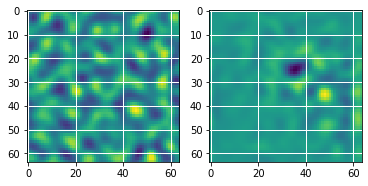

scale = 0.0625 degrees


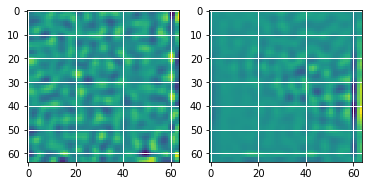

In [411]:
import pywt
from kymatio import Scattering2D
import torchvision.transforms.functional as TF 
import torch

print(names)
plt.subplot(121)
plt.imshow(filtered_ims.sum(axis = (2,3)).T)
plt.grid(color='w', linestyle='-', linewidth=1)
plt.subplot(122)
plt.imshow(filtered_ims.sum(axis = (0,1)).T)
plt.grid(color='w', linestyle='-', linewidth=1)
plt.show()
    
wavelets = ['bior1.1', 'bior2.2', 'bior3.3', 'bior4.4', 'bior5.5', 'bior6.8']

for wv in wavelets: 
    coeff = pywt.swtn(filtered_ims.sum(axis = (2,3)).T, wv, level=4)
    coeff_pm = pywt.swtn(filtered_ims.sum(axis = (0,1)).T, wv, level=4)
    
    
    print(wv)



#scale is calculated as field_degree/# of pixels * 2^j 

    print('scale = 0.5 degrees')
    plt.subplot(121)
    plt.imshow(coeff[0]['aa'])
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(coeff_pm[0]['aa'])
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()

    print('scale = 0.25 degrees')
    plt.subplot(121)
    plt.imshow(coeff[0]['ad'] + coeff[0]['da'] + coeff[0]['dd'])
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(coeff_pm[0]['ad'] + coeff_pm[0]['da'] + coeff_pm[0]['dd'])
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()

    print('scale = 0.125 degrees')
    plt.subplot(121)
    plt.imshow(coeff[1]['ad'] + coeff[1]['da'] + coeff[1]['dd'])
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(coeff_pm[1]['ad'] + coeff_pm[1]['da'] + coeff_pm[1]['dd'])
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()

    print('scale = 0.0625 degrees')
    plt.subplot(121)
    plt.imshow(coeff[2]['ad'] + coeff[2]['da'] + coeff[2]['dd'])
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.subplot(122)
    plt.imshow(coeff_pm[2]['ad'] + coeff_pm[2]['da'] + coeff_pm[2]['dd'])
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.show()

   # plt.subplot(121)
   # plt.imshow(coeff[3]['ad'] + coeff[3]['da'] + coeff[3]['dd'])
   # plt.grid(color='w', linestyle='-', linewidth=1)
   # plt.subplot(122)
   # plt.imshow(coeff_pm[3]['ad'] + coeff_pm[3]['da'] + coeff_pm[3]['dd'])
   # plt.grid(color='w', linestyle='-', linewidth=1)
   # plt.show()


